# Libraries Import

In [1]:
# ==============================================================
# 0. Imports and Setup
# ==============================================================
import os
import glob
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import transforms, datasets
from torchvision.utils import save_image, make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [2]:
# ==============================================================
# 1. Data Loading: CIFAR-10 (cats and dogs only)
# ==============================================================

# Define transformation: resize is not needed if images are already 32x32,
# but ensure the tensor values are in [-1, 1] (for Tanh in generator/decoder).
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Path to training images
train_dataset_path = "/kaggle/input/cifar10-pngs-in-folders/cifar10/train"
full_train_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)
# Filter to only include "cat" and "dog"
selected_classes = ['cat', 'dog']
train_selected_indices = [i for i, (_, label) in enumerate(full_train_dataset.samples)
                          if full_train_dataset.classes[label] in selected_classes]
train_dataset = Subset(full_train_dataset, train_selected_indices)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
print(f"Training dataset loaded with {len(train_dataset)} samples.")

# Assume test images are in a similar folder structure:
test_dataset_path = "/kaggle/input/cifar10-pngs-in-folders/cifar10/test"
full_test_dataset = datasets.ImageFolder(root=test_dataset_path, transform=transform)
test_selected_indices = [i for i, (_, label) in enumerate(full_test_dataset.samples)
                          if full_test_dataset.classes[label] in selected_classes]
test_dataset = Subset(full_test_dataset, test_selected_indices)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)
print(f"Test dataset loaded with {len(test_dataset)} samples.")

Training dataset loaded with 10000 samples.
Test dataset loaded with 2000 samples.


In [3]:
# ==============================================================
# 2. Model Definitions
# ==============================================================

# ---------- 2.1 GAN Components ----------
# Generator for CIFAR-10: generates a 3x32x32 image from a latent vector.
class Generator(nn.Module):
    def __init__(self, latent_dim=150, base_channels=512):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            # Project latent vector to (base_channels) x 4 x 4
            nn.ConvTranspose2d(latent_dim, base_channels, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(base_channels),
            nn.ReLU(True),
            # Upsample: 4x4 -> 8x8
            nn.ConvTranspose2d(base_channels, base_channels // 2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels // 2),
            nn.ReLU(True),
            # Upsample: 8x8 -> 16x16
            nn.ConvTranspose2d(base_channels // 2, base_channels // 4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(base_channels // 4),
            nn.ReLU(True),
            # Upsample: 16x16 -> 32x32
            nn.ConvTranspose2d(base_channels // 4, 3, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Output values in [-1, 1]
        )
    
    def forward(self, z):
        return self.net(z)

# Siamese Discriminator: Extract features from two images and compute similarity.
class SiameseDiscriminator(nn.Module):
    def __init__(self, feature_map_size=64, alpha=1e-6):
        """
        For CIFAR-10, input images are 3x32x32.
        """
        super(SiameseDiscriminator, self).__init__()
        self.alpha = alpha
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(3, feature_map_size, kernel_size=4, stride=2, padding=1),    # 32x32 -> 16x16
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size, feature_map_size*2, kernel_size=4, stride=2, padding=1),  # 16x16 -> 8x8
            nn.BatchNorm2d(feature_map_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(feature_map_size*2, feature_map_size*4, kernel_size=4, stride=2, padding=1),  # 8x8 -> 4x4
            nn.BatchNorm2d(feature_map_size*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )
    
    def forward(self, img1, img2):
        f1 = self.feature_extractor(img1)
        f2 = self.feature_extractor(img2)
        f1 = f1.view(f1.size(0), -1)
        f2 = f2.view(f2.size(0), -1)
        diff = f1 - f2
        dist_sq = torch.sum(diff ** 2, dim=1, keepdim=True)
        score = torch.exp(-self.alpha * dist_sq)
        return score

In [4]:
# ---------- 2.2 VAE Components ----------
# VAE architecture for CIFAR-10 images (3x32x32)
class VAE(nn.Module):
    def __init__(self, latent_dim=512, feature_map_size=64):
        super(VAE, self).__init__()
        # Encoder: 3x32x32 -> downsample to 4x4 feature map
        self.encoder = nn.Sequential(
            nn.Conv2d(3, feature_map_size, kernel_size=4, stride=2, padding=1),      # 32->16
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_map_size, feature_map_size*2, kernel_size=4, stride=2, padding=1),  # 16->8
            nn.BatchNorm2d(feature_map_size*2),
            nn.ReLU(inplace=True),
            nn.Conv2d(feature_map_size*2, feature_map_size*4, kernel_size=4, stride=2, padding=1),  # 8->4
            nn.BatchNorm2d(feature_map_size*4),
            nn.ReLU(inplace=True)
        )
        self.flatten = nn.Flatten()
        self.feature_dim = feature_map_size*4*4*4   # (feature_map_size*4) channels x 4x4
        
        self.fc_mu = nn.Linear(self.feature_dim, latent_dim)
        self.fc_logvar = nn.Linear(self.feature_dim, latent_dim)
        
        # Decoder: latent vector -> reconstruct image
        self.fc_decode = nn.Linear(latent_dim, self.feature_dim)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (feature_map_size*4, 4, 4)),
            nn.ConvTranspose2d(feature_map_size*4, feature_map_size*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_map_size*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(feature_map_size*2, feature_map_size, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(feature_map_size),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(feature_map_size, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output in [-1, 1]
        )
        
    def encode(self, x):
        x_enc = self.encoder(x)
        x_enc = self.flatten(x_enc)
        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        x = self.fc_decode(z)
        x = self.decoder(x)
        return x
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

In [5]:
# ==============================================================
# 3. Loss Functions
# ==============================================================

# --- LS-GAN losses ---
def ls_gan_discriminator_loss(D_real, D_fake):
    loss_real = torch.mean((D_real - 1.0)**2)
    loss_fake = torch.mean(D_fake**2)
    return 0.5 * (loss_real + loss_fake)

def ls_gan_generator_loss(D_fake):
    return 0.5 * torch.mean((D_fake - 1.0)**2)

# --- VAE Loss ---
def vae_loss(recon, x, mu, logvar, kl_weight=0.001):
    recon_loss = nn.functional.l1_loss(recon, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_weight * kl_loss, recon_loss, kl_loss

In [6]:
# ==============================================================
# 4. Optimizers and Schedulers
# ==============================================================

# Hyperparameters for GAN
gan_latent_dim = 150
lr_gen = 2e-4       # You can try increasing the generator LR
lr_disc = 2e-4      # Adjust as needed
beta1 = 0.5

# Instantiate GAN models
generator = Generator(latent_dim=gan_latent_dim, base_channels=512).to(device)
discriminator = SiameseDiscriminator(feature_map_size=64, alpha=1e-6).to(device)

optimizerG = optim.Adam(generator.parameters(), lr=lr_gen, betas=(beta1, 0.999))
optimizerD = optim.Adam(discriminator.parameters(), lr=lr_disc, betas=(beta1, 0.999))

schedulerG = torch.optim.lr_scheduler.StepLR(optimizerG, step_size=50, gamma=0.5)
schedulerD = torch.optim.lr_scheduler.StepLR(optimizerD, step_size=50, gamma=0.5)

# Hyperparameters for VAE
vae_latent_dim = 512
lr_vae = 1e-5

vae = VAE(latent_dim=vae_latent_dim, feature_map_size=64).to(device)
optimizerVAE = optim.Adam(vae.parameters(), lr=lr_vae)
schedulerVAE = torch.optim.lr_scheduler.StepLR(optimizerVAE, step_size=50, gamma=0.5)

# Optional: Feature Matching loss for GAN (helps guide generator)
lambda_fmatch = 0.1
def feature_matching_loss(real_imgs, fake_imgs, discriminator):
    # Extract intermediate features using discriminator.feature_extractor
    real_features = discriminator.feature_extractor(real_imgs)
    fake_features = discriminator.feature_extractor(fake_imgs)
    # Compare average features
    return nn.functional.l1_loss(fake_features.mean(dim=0), real_features.mean(dim=0))

In [7]:
# ==============================================================
# 5. Training Loops
# ==============================================================

# -----------------
# GAN Training Loop
# -----------------
gan_loss_history = {"G": [], "D": []}
num_epochs_gan = 1000  # Adjust number of epochs for GAN training

print("Starting GAN Training...")

# For adversarial updates, we can alternate updates:
# Here, for simplicity, we update both networks every batch.
for epoch in range(1, num_epochs_gan + 1):
    for i, (imgs, _) in enumerate(train_loader):
        batch_size = imgs.size(0)
        real_imgs = imgs.to(device)
        
        # --- Update Discriminator ---
        noise = torch.randn(batch_size, gan_latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)
        D_real = discriminator(real_imgs, real_imgs)    # Should be ~1
        D_fake = discriminator(real_imgs, fake_imgs.detach())  # Should be ~0
        
        optimizerD.zero_grad()
        loss_D = ls_gan_discriminator_loss(D_real, D_fake)
        loss_D.backward()
        optimizerD.step()
        gan_loss_history["D"].append(loss_D.item())
        
        # --- Update Generator ---
        noise = torch.randn(batch_size, gan_latent_dim, 1, 1, device=device)
        fake_imgs = generator(noise)
        D_fake = discriminator(real_imgs, fake_imgs)
        optimizerG.zero_grad()
        loss_G_adv = ls_gan_generator_loss(D_fake)
        # Optionally add feature matching loss:
        fmatch_loss = feature_matching_loss(real_imgs, fake_imgs, discriminator)
        loss_G_total = loss_G_adv + lambda_fmatch * fmatch_loss
        loss_G_total.backward()
        optimizerG.step()
        gan_loss_history["G"].append(loss_G_total.item())
        
        if i % 100 == 0:
            print(f"[GAN] Epoch [{epoch}/{num_epochs_gan}] Batch [{i}/{len(train_loader)}] "
                  f"Loss_D: {loss_D.item():.4f} Loss_G: {loss_G_total.item():.4f}")
    
    schedulerG.step()
    schedulerD.step()
    
    # Save sample outputs for the GAN after each epoch.
    sample_folder_gan = "gan_samples"
    os.makedirs(sample_folder_gan, exist_ok=True)
    with torch.no_grad():
        num_samples = min(5, real_imgs.size(0))
        real_sample = real_imgs[:num_samples]
        noise_sample = torch.randn(num_samples, gan_latent_dim, 1, 1, device=device)
        fake_sample = generator(noise_sample)
        grid = torchvision.utils.make_grid(torch.cat([real_sample, fake_sample], dim=0),
                                             nrow=num_samples, normalize=True)
        save_image(grid, os.path.join(sample_folder_gan, f"epoch_{epoch}.png"))
    
    print(f"Epoch {epoch} complete (GAN).")

print("GAN Training Completed.")

Starting GAN Training...
[GAN] Epoch [1/1000] Batch [0/157] Loss_D: 0.4949 Loss_G: 0.0192
[GAN] Epoch [1/1000] Batch [100/157] Loss_D: 0.4903 Loss_G: 0.0191
Epoch 1 complete (GAN).
[GAN] Epoch [2/1000] Batch [0/157] Loss_D: 0.4906 Loss_G: 0.0136
[GAN] Epoch [2/1000] Batch [100/157] Loss_D: 0.4893 Loss_G: 0.0131
Epoch 2 complete (GAN).
[GAN] Epoch [3/1000] Batch [0/157] Loss_D: 0.4884 Loss_G: 0.0154
[GAN] Epoch [3/1000] Batch [100/157] Loss_D: 0.4895 Loss_G: 0.0155
Epoch 3 complete (GAN).
[GAN] Epoch [4/1000] Batch [0/157] Loss_D: 0.4878 Loss_G: 0.0140
[GAN] Epoch [4/1000] Batch [100/157] Loss_D: 0.4873 Loss_G: 0.0149
Epoch 4 complete (GAN).
[GAN] Epoch [5/1000] Batch [0/157] Loss_D: 0.4866 Loss_G: 0.0161
[GAN] Epoch [5/1000] Batch [100/157] Loss_D: 0.4859 Loss_G: 0.0150
Epoch 5 complete (GAN).
[GAN] Epoch [6/1000] Batch [0/157] Loss_D: 0.4859 Loss_G: 0.0153
[GAN] Epoch [6/1000] Batch [100/157] Loss_D: 0.4852 Loss_G: 0.0152
Epoch 6 complete (GAN).
[GAN] Epoch [7/1000] Batch [0/157] Loss

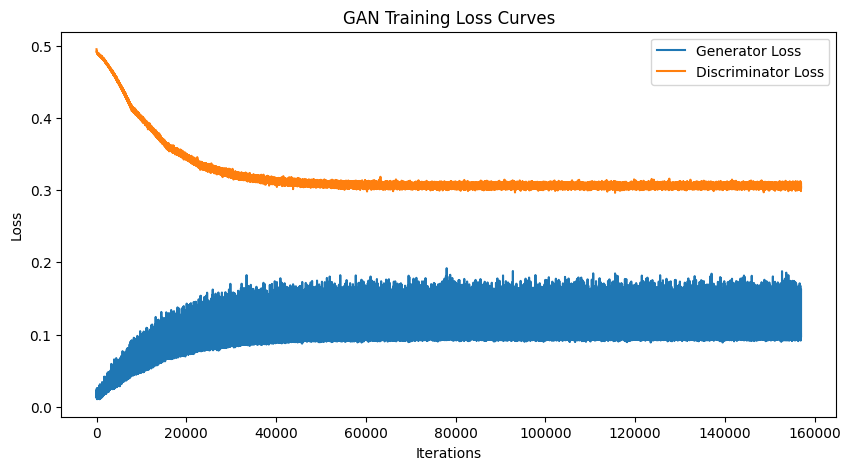

In [8]:
plt.figure(figsize=(10,5))
plt.plot(gan_loss_history["G"], label="Generator Loss")
plt.plot(gan_loss_history["D"], label="Discriminator Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("GAN Training Loss Curves")
plt.legend()
plt.show()

In [9]:
# -----------------
# VAE Training Loop
# -----------------
vae_loss_history = {"total": [], "recon": [], "kl": []}
num_epochs_vae = 1000  # Adjust as needed

print("Starting VAE Training...")
vae.train()
for epoch in range(1, num_epochs_vae + 1):
    for i, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device)
        optimizerVAE.zero_grad()
        recon, mu, logvar = vae(imgs)
        total_loss, recon_loss, kl_loss = vae_loss(recon, imgs, mu, logvar, kl_weight=0.001)
        total_loss.backward()
        optimizerVAE.step()
        vae_loss_history["total"].append(total_loss.item())
        vae_loss_history["recon"].append(recon_loss.item())
        vae_loss_history["kl"].append(kl_loss.item())
        if i % 100 == 0:
            print(f"[VAE] Epoch [{epoch}/{num_epochs_vae}] Batch [{i}/{len(train_loader)}] Loss: {total_loss.item():.4f} Recon: {recon_loss.item():.4f} KL: {kl_loss.item():.4f}")
    schedulerVAE.step()
    
    # Save reconstructed samples for VAE after each epoch.
    sample_folder_vae = "vae_samples"
    os.makedirs(sample_folder_vae, exist_ok=True)
    with torch.no_grad():
        recon, _, _ = vae(imgs)
        imgs_denorm = (imgs + 1) / 2
        recon_denorm = (recon + 1) / 2
        n = min(8, imgs.size(0))
        grid_orig = torchvision.utils.make_grid(imgs_denorm[:n], nrow=n)
        grid_recon = torchvision.utils.make_grid(recon_denorm[:n], nrow=n)
        combined = torch.cat([grid_orig, grid_recon], dim=1)
        save_image(combined, os.path.join(sample_folder_vae, f"epoch_{epoch}.png"))
    print(f"Epoch {epoch} complete (VAE).")

print("VAE Training Completed.")

Starting VAE Training...
[VAE] Epoch [1/1000] Batch [0/157] Loss: 130341.7734 Recon: 130337.7109 KL: 4065.3894
[VAE] Epoch [1/1000] Batch [100/157] Loss: 102816.2891 Recon: 102799.0859 KL: 17204.6367
Epoch 1 complete (VAE).
[VAE] Epoch [2/1000] Batch [0/157] Loss: 82990.3359 Recon: 82949.4453 KL: 40892.4766
[VAE] Epoch [2/1000] Batch [100/157] Loss: 69997.4688 Recon: 69941.7812 KL: 55687.2344
Epoch 2 complete (VAE).
[VAE] Epoch [3/1000] Batch [0/157] Loss: 63010.2617 Recon: 62951.5156 KL: 58747.1523
[VAE] Epoch [3/1000] Batch [100/157] Loss: 57808.6797 Recon: 57740.7812 KL: 67898.9375
Epoch 3 complete (VAE).
[VAE] Epoch [4/1000] Batch [0/157] Loss: 57951.4727 Recon: 57877.4258 KL: 74048.5000
[VAE] Epoch [4/1000] Batch [100/157] Loss: 49288.8281 Recon: 49210.4062 KL: 78422.2188
Epoch 4 complete (VAE).
[VAE] Epoch [5/1000] Batch [0/157] Loss: 51214.1562 Recon: 51136.5352 KL: 77619.7109
[VAE] Epoch [5/1000] Batch [100/157] Loss: 45298.6328 Recon: 45216.3828 KL: 82249.5156
Epoch 5 complete

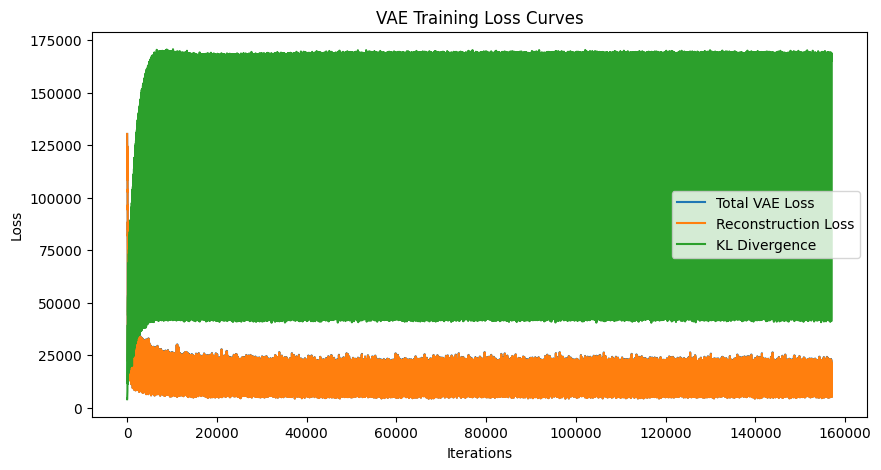

In [10]:
plt.figure(figsize=(10,5))
plt.plot(vae_loss_history["total"], label="Total VAE Loss")
plt.plot(vae_loss_history["recon"], label="Reconstruction Loss")
plt.plot(vae_loss_history["kl"], label="KL Divergence")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("VAE Training Loss Curves")
plt.legend()
plt.show()

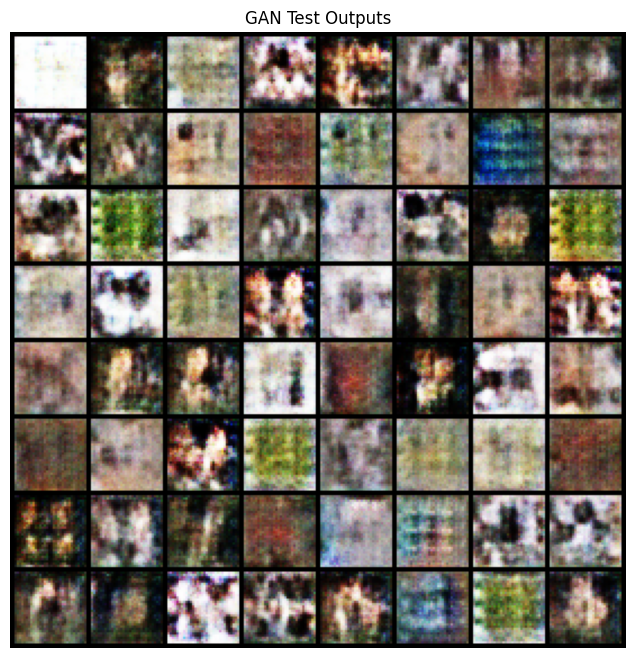

In [11]:
# ==============================================================
# 6. Testing Code
# ==============================================================
# --- Testing GAN ---
generator.eval()
with torch.no_grad():
    noise = torch.randn(64, gan_latent_dim, 1, 1, device=device)
    fake_test = generator(noise)
    fake_test = (fake_test + 1) / 2  # Denormalize to [0,1]
    grid_test = make_grid(fake_test, nrow=8)
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(grid_test.cpu().numpy(), (1,2,0)))
    plt.title("GAN Test Outputs")
    plt.axis("off")
    plt.show()
    save_image(fake_test, "gan_test_outputs.png", nrow=8, normalize=True)

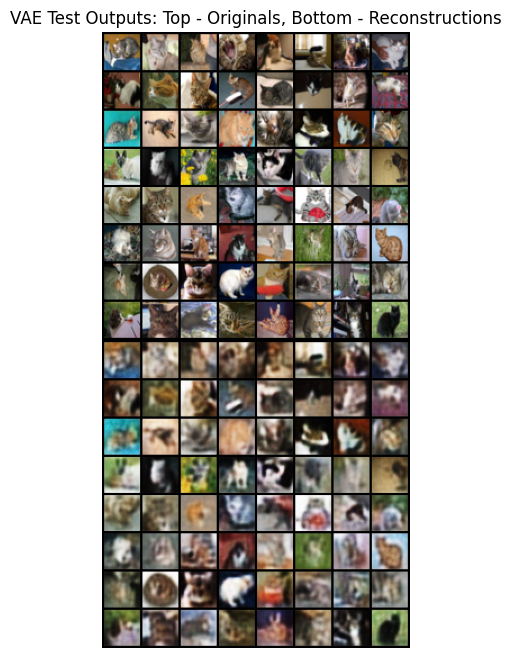

In [12]:
# --- Testing VAE ---
vae.eval()
with torch.no_grad():
    data_iter = iter(test_loader)
    test_imgs, _ = next(data_iter)
    test_imgs = test_imgs.to(device)
    recon_test, _, _ = vae(test_imgs)
    test_imgs_denorm = (test_imgs + 1) / 2
    recon_test_denorm = (recon_test + 1) / 2
    grid_orig = make_grid(test_imgs_denorm, nrow=8)
    grid_recon = make_grid(recon_test_denorm, nrow=8)
    combined_test = torch.cat([grid_orig, grid_recon], dim=1)
    plt.figure(figsize=(16,8))
    plt.imshow(np.transpose(combined_test.cpu().numpy(), (1,2,0)))
    plt.title("VAE Test Outputs: Top - Originals, Bottom - Reconstructions")
    plt.axis("off")
    plt.show()
    save_image(combined_test, "vae_test_outputs.png", normalize=True)